# Predecir los precios de la vivienda en Boston usando AWS Sagemaker


## Uso de XGBoost en SageMaker (Implementar)

_Programa de Nanogrado de Aprendizaje Profundo | Despliegue_

---

Como introducción al uso de la API de Python de alto nivel de SageMaker, veremos un problema relativamente simple. Es decir, utilizaremos el [Conjunto de datos de viviendas de Boston] (https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) para predecir el valor medio de una casa en el área de Boston Mass.

La documentación para la API de alto nivel se puede encontrar en la [página ReadTheDocs] (http://sagemaker.readthedocs.io/en/latest/)

## Bosquejo general

Por lo general, cuando utilice una instancia de notebook con SageMaker, seguirá los siguientes pasos. Por supuesto, no será necesario realizar todos los pasos con cada proyecto. Además, hay bastante margen de variación en muchos de los pasos, como verá a lo largo de estas lecciones.

1. Descargue o recupere los datos.
2. Procesar / preparar los datos.
3. Cargue los datos procesados ​​en S3.
4. Entrene un modelo elegido.
5. Pruebe el modelo entrenado (normalmente utilizando un trabajo de transformación por lotes).
6. Implemente el modelo entrenado.
7. Utilice el modelo implementado.

En este cuaderno nos saltaremos el paso 5, probando el modelo. Seguiremos probando el modelo, pero lo haremos implementando primero el modelo y luego enviando los datos de prueba al modelo implementado.

In [1]:
#!pip install -U sagemaker
# Make sure that we use SageMaker 2.x
!pip install sagemaker==2.31.1

## Paso 0: Configurar el cuaderno

Comenzamos configurando todos los paquetes necesarios para ejecutar nuestro portátil. Para comenzar, eso significa cargar todos los módulos de Python que necesitaremos.

In [2]:
%matplotlib inline

%matplotlib inline

import os
import time
from time import gmtime, strftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

Además de los módulos anteriores, necesitamos importar los distintos paquetesde SageMaker que usaremos.

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.predictor import csv_serializer
import boto3

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## Paso 1: Descargar los datos

Afortunadamente, este conjunto de datos se puede recuperar mediante sklearn, por lo que este paso es relativamente sencillo.

In [4]:
boston = load_boston()

## Paso 2: preparar y dividir los datos

Dado que se trata de datos tabulares limpios, no es necesario realizar ningún procesamiento. Sin embargo, necesitamos dividir las filas del conjunto de datos en conjuntos de entrenamiento, prueba y validación.

In [5]:
# Primero empaquetamos los datos de entrada y la variable de destino (el valor mediano) como marcos de datos de pandas. Esto
# hará que guardar los datos en un archivo sea un poco más fácil más adelante.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# dividimos los dataset en 2/3 training y 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Luego dividimos el conjunto de entrenamiento en 2/3 de entrenamiento y 1/3 de conjuntos de validación.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Paso 3: Subir los archivos de datos a S3

Cuando se construye un trabajo de entrenamiento usando SageMaker, se ejecuta un contenedor que realiza la operación de entrenamiento. Este contenedor tiene acceso a los datos almacenados en S3. Esto significa que necesitamos cargar los datos que queremos usar para entrenar a S3. Además, cuando realizamos un trabajo de transformación por lotes, SageMaker espera que los datos de entrada se almacenen en S3. Podemos usar la API de SageMaker para hacer esto y ocultar algunos de los detalles.

### Guarda los datos localmente

Primero necesitamos crear los archivos csv de prueba, entrenamiento y validación que luego cargaremos en S3.

In [6]:
# Nos aseguramos que exista el directorio local con la data 
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [7]:
# Usamos pandas para guardar nuestros datos de prueba, entrenamiento y validación en archivos csv. 
# Tenga en cuenta que nos aseguramos de no incluir el encabezado
# información o un índice, ya que esto es requerido por los algoritmos integrados proporcionados por Amazon. 
# Además, para el tren y datos de validación, se asume que la primera entrada en cada fila es la variable objetivo.

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Creamos el bucket en S3 usando este código

#### no es necesario tener buckets creados previamente pero el IAM role que usas debe tener los permisos: AmazonS3FullAccess y AmazonSageMakerFullAccess

In [8]:
# Aquí hago la creación del bucket en S3 con el nombre que va en la variable prefix 
# y subo al bucket los datos que tengo en la instancia de notebook (que mueren cuando elimino la instancia)

prefix = 'boston-xgboost-deploy-hl'

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Paso 4: Entrena y construye el modelo XGBoost

Ahora que tenemos los datos de entrenamiento y validación cargados en S3, podemos construir un trabajo de entrenamiento para nuestro modelo XGBoost y construir el modelo en sí.

### Configurar el trabajo de entrenamiento

Primero, configuraremos y ejecutaremos un trabajo de entrenamiento para nuestro modelo. Para hacer esto, necesitamos especificar cierta información que SageMaker utilizará para configurar y ejecutar correctamente el cálculo. Para obtener documentación adicional sobre cómo construir un trabajo de entrenamiento, consulte la referencia de la [API CreateTrainingJob] (https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html).

### Creamos el container

In [9]:
# We will need to know the name of the container that we want to use for training. SageMaker provides
# a nice utility method to construct this for us.
container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, '1')
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1'

In [10]:
# We now specify the parameters we wish to use for our training job
training_params = {}

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# También necesitamos decir dónde nos gustaría almacenar los artefactos del modelo resultante.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# También necesitamos establecer algunos parámetros para el trabajo de entrenamiento en sí. Es decir, 
# necesitamos describir qué tipo de instancia de cálculo que deseamos usar junto con una condición 
# de detención para manejar el caso de que haya algún tipo de error y el script de entrenamiento no termina.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# A continuación, configuramos los hiperparámetros específicos del algoritmo. Es posible que desee cambiarlos para ver qué efecto
# hay en el modelo resultante.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Ahora necesitamos decirle a SageMaker de dónde se deben recuperar los datos.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

### Creamos el trabajo

In [11]:
# Primero tenemos que elegir un nombre de trabajo de formación. 
# Esto es útil si queremos recordar información sobre nuestro trabajo de formación en una fecha posterior. 
# Tenga en cuenta que SageMaker requiere un nombre de trabajo de formación y que el nombre debe
# ser único, lo que logramos agregando la marca de tiempo actual.
training_job_name = "boston-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# Y ahora le pedimos a SageMaker que cree (y ejecute) el trabajo de entrenamiento
training_job = session.sagemaker_client.create_training_job(**training_params)
#El trabajo de entrenamiento ahora ha sido creado por SageMaker y se está ejecutando actualmente. 
# Dado que necesitamos el resultado del trabajo de entrenamiento, 
# es posible que deseemos esperar hasta que haya finalizado. 
#Podemos hacerlo pidiendo a SageMaker que genere los registros generados por el trabajo de entrenamiento 
#y continuar haciéndolo hasta que finalice el trabajo de entrenamiento.
session.logs_for_job(training_job_name, wait=True)

2021-04-26 07:04:31 Starting - Starting the training job...
2021-04-26 07:04:50 Starting - Launching requested ML instances.........
2021-04-26 07:06:07 Starting - Preparing the instances for training......
2021-04-26 07:07:22 Downloading - Downloading input data...
2021-04-26 07:07:56 Training - Downloading the training image...
2021-04-26 07:08:23 Uploading - Uploading generated training modelArguments: train
[2021-04-26:07:08:19:INFO] Running standalone xgboost training.
[2021-04-26:07:08:19:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8425.08mb
[2021-04-26:07:08:19:INFO] Determined delimiter of CSV input is ','
[07:08:19] S3DistributionType set as FullyReplicated
[07:08:19] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-04-26:07:08:19:INFO] Determined delimiter of CSV input is ','
[07:08:19] S3DistributionType set as FullyReplicated
[07:08:19] 112x13 matrix with 1456 en

In [12]:
# Comenzamos pidiendo a SageMaker que nos describa los resultados del trabajo de entrenamiento
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [13]:
# Al igual que cuando creamos un trabajo de entrenamiento, el nombre del modelo debe ser único
model_name = training_job_name + "-model"

# También necesitamos decirle a SageMaker qué contenedor debe usarse para la inferencia y dónde debe
# recuperar los artefactos del modelo. En nuestro caso, el contenedor xgboost que usamos para entrenar
# también se puede utilizar para inferencias.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# Y por último construimos el modelo SageMaker
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## Paso 5: prueba el modelo entrenado

Saltaremos este paso por ahora. Seguiremos probando nuestro modelo entrenado, pero lo haremos utilizando el modelo implementado, en lugar de configurar un trabajo de transformación por lotes.


## Paso 6: crear e implementar el punto final

Ahora que hemos entrenado y construido un modelo, es hora de crear el punto final asociado e implementarlo. Como en los pasos anteriores, primero debemos construir la configuración adecuada.

In [14]:
# Como antes, necesitamos darle a nuestra configuración de punto final un nombre que debería ser único.
endpoint_config_name = "boston-xgboost-endpoint-config-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# le pedimos a SageMaker que construya la configuración del endpoint
endpoint_config_info = session.sagemaker_client.create_endpoint_config(
                            EndpointConfigName = endpoint_config_name,
                            ProductionVariants = [{
                                "InstanceType": "ml.m4.xlarge",
                                "InitialVariantWeight": 1,
                                "InitialInstanceCount": 1,
                                "ModelName": model_name,
                                "VariantName": "AllTraffic"
                            }])

Y ahora que se ha creado la configuración del punto final, podemos implementar el punto final en sí.

**NOTA:** Al implementar un modelo, le está pidiendo a SageMaker que lance una instancia  que esperará a que se le envíen datos. Como resultado, esta instancia continuará ejecutándose hasta que * usted * la apague. Es importante saber esto, ya que el costo de un endpoint implementado depende de cuánto tiempo ha estado funcionando.

En otras palabras ** Si ya no usa el endpoint implementado, ¡apáguelo! **

In [15]:
# Necesitamos nuevamente crear un nombre único para nuestro endpoint
endpoint_name = "boston-xgboost-endpoint-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# acá hacemos el depliegue del endpoint
endpoint_info = session.sagemaker_client.create_endpoint(
                    EndpointName = endpoint_name,
                    EndpointConfigName = endpoint_config_name)

Al igual que cuando creamos un trabajo de capacitación, SageMaker ahora está solicitando y lanzando nuestro endpoint. Dado que no podemos hacer mucho hasta que el punto final se haya implementado por completo, podemos esperar a que finalice.

In [16]:
endpoint_dec = session.wait_for_endpoint(endpoint_name)

---------------!

## Paso 7: Usa el modelo

Ahora que nuestro modelo está entrenado e implementado, podemos enviarle datos de prueba y evaluar los resultados. Aquí, debido a que nuestros datos de prueba son tan pequeños, podemos enviarlos todos con una sola llamada a nuestro punto final. Si nuestro conjunto de datos de prueba fuera más grande, tendríamos que dividirlo y enviar los datos en trozos, asegurándonos de acumular los resultados.

In [31]:
# Primero necesitamos serializar los datos de entrada. En este caso, queremos enviar los datos de prueba como un csv 
# así que hacemos esto manualmente ya que no tenemos un objeto Predictor. 
# Por supuesto, hay muchas otras formas de hacer esto.
payload = [[str(entry) for entry in row] for row in X_test.values]
payload = '\n'.join([','.join(row) for row in payload])

In [30]:
print(type(X_test.values))
print(type(payload))

<class 'numpy.ndarray'>
<class 'str'>


In [18]:
# Esta vez, usamos el cliente de ejecución de sagemaker en vez del cliente de sagemaker para poder invocar el endpoint
response = session.sagemaker_runtime_client.invoke_endpoint(
                                                EndpointName = endpoint_name,
                                                ContentType = 'text/csv',
                                                Body = payload)

# Necesitamos asegurarnos de deserializar el resultado de nuestra llamada de punto final.
result = response['Body'].read().decode("utf-8")
Y_pred = np.fromstring(result, sep=',')

Para ver qué tan bien funciona nuestro modelo, podemos crear un diagrama de dispersión simple entre los valores predichos y reales. Si el modelo fuera completamente preciso, el diagrama de dispersión resultante se vería como la línea $ x = y $. Como podemos ver, nuestro modelo parece haber funcionado bien, pero hay margen de mejora.

Text(0.5, 1.0, 'Median Price vs Predicted Price')

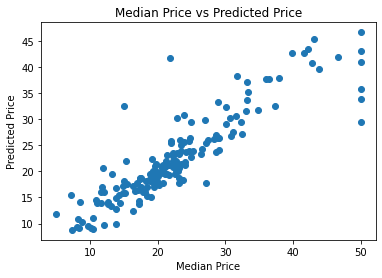

In [19]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Eliminar el endpoint

Dado que ya no usamos el modelo implementado, debemos asegurarnos de apagarlo. Recuerde que debe pagar por la cantidad de tiempo que su punto final está implementado, por lo que cuanto más tiempo se deja en funcionamiento, más cuesta.

In [20]:
#esession.sagemaker_client.delete_endpoint(EndpointName = endpoint_name)

## Opcional: Limpiar

La instancia de portátil predeterminada en SageMaker no tiene mucho espacio disponible en disco. A medida que continúe completando y ejecutando cuadernos, eventualmente llenará este espacio en el disco, lo que generará errores que pueden ser difíciles de diagnosticar. Una vez que haya terminado de usar un cuaderno, es una buena idea eliminar los archivos que creó durante el proceso. Por supuesto, puede hacerlo desde el terminal o desde el concentrador del portátil si lo desea. La celda a continuación contiene algunos comandos para limpiar los archivos creados desde dentro del cuaderno.

In [21]:
# First we will remove all of the files contained in the data_dir directory
#!rm $data_dir/*

# And then we delete the directory itself
#!rmdir $data_dir